# Introduction
In this tutorial, we will learn how to use the PuLP library in Python to solve linear programming problems. Linear programming is a method to achieve the best outcome in a mathematical model whose requirements are represented by linear constraints.

In [1]:
#Install pulp
%pip install pulp

     ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
     --------------------------------------- 0.1/16.4 MB 907.3 kB/s eta 0:00:18
     --------------------------------------- 0.1/16.4 MB 980.4 kB/s eta 0:00:17
     ---------------------------------------- 0.2/16.4 MB 1.2 MB/s eta 0:00:14
      -------------------------------------- 0.2/16.4 MB 981.9 kB/s eta 0:00:17
      --------------------------------------- 0.4/16.4 MB 1.3 MB/s eta 0:00:12
     - -------------------------------------- 0.5/16.4 MB 1.6 MB/s eta 0:00:10
     - -------------------------------------- 0.6/16.4 MB 1.7 MB/s eta 0:00:10
     - -------------------------------------- 0.7/16.4 MB 1.7 MB/s eta 0:00:10
     - -------------------------------------- 0.7/16.4 MB 1.7 MB/s eta 0:00:10
     -- ------------------------------------- 1.0/16.4 MB 1.9 MB/s eta 0:00:08
     -- ------------------------------------- 1.1/16.4 MB 1.9 M

ERROR: Could not install packages due to an OSError: [WinError 2] Nie można odnaleźć określonego pliku: 'c:\\Python310\\Scripts\\pulptest.exe' -> 'c:\\Python310\\Scripts\\pulptest.exe.deleteme'


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import the library
import random
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus

## Problem Formulation
Let's consider a simple problem:

Maximize: $$Z = 4x + 3y$$
Subject to:
$$2x + y \leq 20$$
$$x + y \leq 12$$
$$x, y \geq 0$$

In [3]:


# Create a problem variable:
prob = LpProblem("Maximize_the_profit_Z", LpMaximize)

# Create problem variables:
x = LpVariable("x", lowBound=0, upBound=None) # x>=0
y = LpVariable("y", lowBound=0, upBound=None) # y>=0


In linear programming problems, the objective function represents the quantity which needs to be minimized or maximized. It does not have constraints like `<=` or `>=`. On the other hand, constraints are the restrictions or limitations on the variables. They have a certain form based on the problem requirements, often represented with `<=`, `>=`, or `==`.

In [4]:

# The objective function and constraints are added using the += operator to our model.
# Objective function Z
prob += 4*x + 3*y, "Profit"

# Constraints
prob += 2*x + y <= 20
prob += x + y <= 12

<b>Note: The names of variables or constraints must be unique and special characters must not appear, e.g. `=`,`<`,`>`.

In [5]:
# Problem
prob

Maximize_the_profit_Z:
MAXIMIZE
4*x + 3*y + 0
SUBJECT TO
_C1: 2 x + y <= 20

_C2: x + y <= 12

VARIABLES
x Continuous
y Continuous

In [6]:
# Solve the problem
prob.solve()
print("Status:", LpStatus[prob.status])

# Print the optimal production amount of x and y
for v in prob.variables():
    print(v.name, "=", v.varValue)

# Print the optimal profit
print("Total profit is: ", value(prob.objective))

Status: Optimal
x = 8.0
y = 4.0
Total profit is:  44.0


# Second Example: Solving a Knapsack Problem
In this example, we will solve a knapsack problem. We have a set of items, each with a weight and a value, and we want to determine the number of each item to include in a collection so that the total weight is less than or equal to a given limit and the total value is as large as possible.

Maximize:
$$Z = 50x_1 + 100x_2 + 120x_3$$
Subject to:
$$10x_1 + 20x_2 + 30x_3 \leq 50$$
$$x_1, x_2, x_3  \in \{0,1\}$$

In [7]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem(name="Knapsack_Problem", sense=LpMaximize)

# The 3 binary variables that can only take values of 0 or 1
x1 = LpVariable(name="Item1", cat='Binary')
x2 = LpVariable(name="Item2", cat='Binary')
x3 = LpVariable(name="Item3", cat='Binary')

# The objective function is added to 'prob'
prob += lpSum([50*x1, 100*x2, 120*x3]), "Total Value of Items in Knapsack"

# Constraint
prob += lpSum([10*x1, 20*x2, 30*x3]) <= 50, "Total Weight of Items in Knapsack"

In [8]:
# Solve the problem
prob.solve()
print("Status:", LpStatus[prob.status])

# Print the optimal solution
for v in prob.variables():
    print(v.name, "=", v.varValue)

# Print the optimal total value
print("Total value of items in knapsack is: ", value(prob.objective))

Status: Optimal
Item1 = 0.0
Item2 = 1.0
Item3 = 1.0
Total value of items in knapsack is:  220.0


# Third Example: Using Binary Variables as Switches
In this example, we will use a binary variable as a switch to control whether certain constraints are active or not. This is a common technique in linear programming when we want to model conditional constraints.

Maximize: $$Z = b_1 + b_2 + b_3$$
Subject to:
$$x + y + M(1-b_1) \geq 50$$
$$x + 2y + M b_1 \leq 100$$
$$3x + 2y + M(1-b_2) \geq 50$$
$$-x + 5y + M b_3 > 75$$
$$x \geq 0, x \leq 8$$
$$y \geq 0$$
$$b_1, b_2, b_3 \in \{0,1\}$$

In [9]:
prob = LpProblem(name="Switch_Problem", sense=LpMaximize)

# The variables are created
x = LpVariable(name="x", lowBound=0,upBound=8)
y = LpVariable(name="y", lowBound=0)
b1 = LpVariable(name="b1", cat='Binary')
b2 = LpVariable(name="b2", cat='Binary')
b3 = LpVariable(name="b3", cat='Binary')

# The objective function is added to 'prob' first
prob += lpSum([b1,b2,b3]), "Total Value"


M = 1000  # A very large number
eps = 0.00001# A very small number
prob += lpSum([x, y]) + M*(1-b1)>= 50 , "Weight constraint when b1 is 1"
prob += lpSum([x, 2*y]) + M*b1 <= 100 , "Weight constraint when b1 is 0"
prob += lpSum([3*x, 2*y]) + M*(1-b2)>= 50 , "Weight constraint when b2 is 1"
# It is not possible to model sharp inequalities `>` or `<` in solver,
# in order to model them a small epsilon value is added artificially to the non-sharp equations.
prob += lpSum([-x, 5*y]) + M*b3 >= 75+eps , "Weight constraint when b3 is 0"


In [10]:
# Solve the problem
prob.solve()
print("Status:", LpStatus[prob.status])

# Print the optimal solution
for v in prob.variables():
    print(v.name, "=", v.varValue)

# Print the optimal total value
print("Total value is: ", value(prob.objective))

Status: Optimal
b1 = 0.0
b2 = 1.0
b3 = 1.0
x = 8.0
y = 13.0
Total value is:  2.0


# Fourth example: A simplified version of the UTA method

The following is an example code solving the problem of ranking alternatives using the UTA method. Consider a problem with two competing criteria C_1 and C_2.

The following example demonstrates the application of the UTA method for ranking alternatives based on two competing criteria, $C_1$ and $C_2$.  

- Criterion $C_1$ is evaluated using numerical values \($[0, 25, 50, 75, 100]$ (0: least preferred, 100: most preferred)\),

- Criterion $C_2$ is assessed using qualitative ratings \($['Bad', 'Poor', 'Neutral', 'Good', 'Excellent']$ ('Bad': worst, 'Excellent': best)\).

Both criteria are relevant, but their weights can not exceed $0.75$.

In this example, four reference alternatives are randomly assigned values from the available criteria levels. In real-world applications, these values would be determined by a decision maker.

Additionally, the decision maker provides preference information, stating that:
-  $a_1 > a_2$
-  $a_1 > a_3$
-  $a_2 > a_4$

The objective of this setup is not to optimize some objective function but rather to verify whether a system of equations satisfying these preferences has a feasible solution.

Run this example several times and see that for some data sets there is a solution and for some the system of equations is contradictory.

Skala kryteriów: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Dynamiczna skala: [0.   0.25 0.34 0.35 0.4  0.44 0.45 0.48 0.55 0.56 0.57 0.62 0.66 0.71
 0.8  0.83 0.86 0.88 0.91 0.95 0.97 1.  ]
Ranking wariantów (od najlepszego):
1. Wariant 16: Użyteczność = 1.0000
2. Wariant 19: Użyteczność = 1.0000
3. Wariant 10: Użyteczność = 1.0000
4. Wariant 26: Użyteczność = 0.8900
5. Wariant 5: Użyteczność = 0.8900
6. Wariant 2: Użyteczność = 0.8900
7. Wariant 21: Użyteczność = 0.8900
8. Wariant 25: Użyteczność = 0.8000
9. Wariant 13: Użyteczność = 0.7900
10. Wariant 3: Użyteczność = 0.2000

Wartość funkcji celu (suma użyteczności): 8.3500


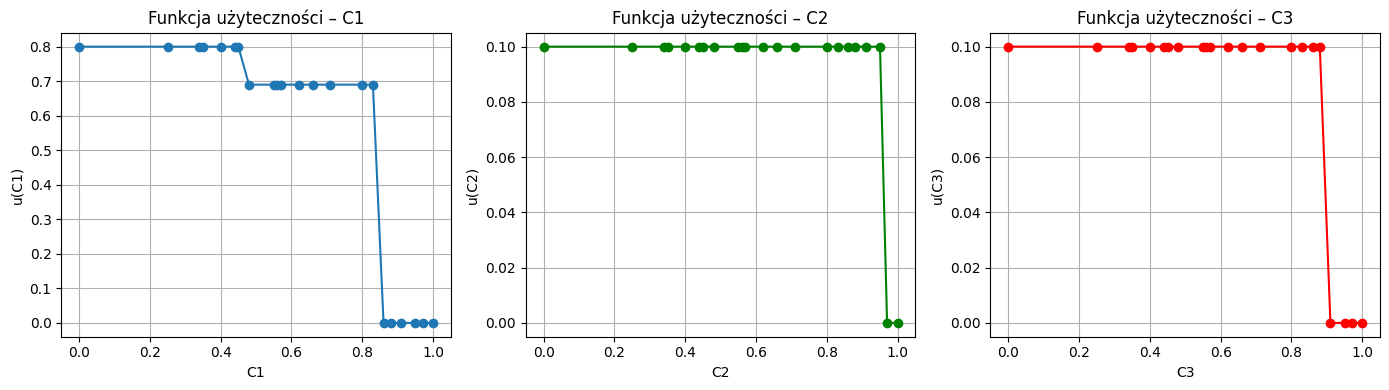

In [21]:
import pandas as pd
import numpy as np 

# Dane wejściowe referencyjne
data_ref = {
    "index": [13, 25, 3, 26, 5, 16, 2, 19, 10, 21],
    "C1": [0.48, 0.34, 1.00, 0.71, 0.62, 0.44, 0.66, 0.35, 0.45, 0.83],
    "C2": [0.97, 1.00, 0.45, 0.25, 0.40, 0.95, 0.55, 0.91, 0.86, 0.25],
    "C3": [0.00, 1.00, 0.57, 0.88, 0.56, 0.00, 0.45, 0.00, 0.00, 0.80],
}
df = pd.DataFrame(data_ref)

# Skale kryteriów (0 do 1 z krokiem co 0.1)
scale = np.round(np.linspace(0, 1, 11), 2)
print("Skala kryteriów:", scale)

# Tworzenie skali tylko z unikalnych wartości z danych
all_vals = np.concatenate([df["C1"], df["C2"], df["C3"]])
scale = np.sort(np.unique(np.round(all_vals, 2)))
print("Dynamiczna skala:", scale)

# Problem optymalizacyjny
prob = LpProblem("UTA_Method", LpMaximize)

# Zmienne decyzyjne – cząstkowe funkcje użyteczności
u_C1 = {val: LpVariable(f"u_C1_{val}", lowBound=0, upBound=1) for val in scale}
u_C2 = {val: LpVariable(f"u_C2_{val}", lowBound=0, upBound=1) for val in scale}
u_C3 = {val: LpVariable(f"u_C3_{val}", lowBound=0, upBound=1) for val in scale}

    
# Monotoniczność odwrotna (koszt – im wyżej, tym gorzej)
for i in range(len(scale) - 1):
    prob += u_C1[scale[i]] >= u_C1[scale[i + 1]]
    prob += u_C2[scale[i]] >= u_C2[scale[i + 1]]
    prob += u_C3[scale[i]] >= u_C3[scale[i + 1]]

prob += u_C1[1] == 0
prob += u_C2[1] == 0
prob += u_C3[1] == 0
prob += u_C1[0] + u_C2[0] + u_C3[0] == 1
prob += u_C1[0] >= 0.1
prob += u_C2[0] >= 0.1
prob += u_C3[0] >= 0.1


# Funkcja do interpolacji
def interpolate(val, u_dict):
    lower = max([v for v in scale if v <= val])
    upper = min([v for v in scale if v >= val])
    if lower == upper:
        return u_dict[lower]
    alpha = (val - lower) / (upper - lower)
    return (1 - alpha) * u_dict[lower] + alpha * u_dict[upper]

# Zmienne dla użyteczności wariantów
utilities = {}
for i, row in df.iterrows():
    idx = int(row["index"])
    util = LpVariable(f"U_{idx}", lowBound=0, upBound=1)
    utilities[idx] = util

    uc1 = interpolate(row["C1"], u_C1)
    uc2 = interpolate(row["C2"], u_C2)
    uc3 = interpolate(row["C3"], u_C3)
    prob += util == uc1 + uc2 + uc3

# Preferencje decydenta:
epsilon = 0.01
prob += utilities[25] >= utilities[13] + epsilon  # produkcja energii i brak pożyczek
prob += utilities[13] >= utilities[3] + epsilon   # R2 > R1 > R3

# Funkcja celu – maksymalizacja sumy użyteczności
prob += lpSum([utilities[k] for k in utilities])

# Rozwiązywanie
prob.solve()

# Wyniki: użyteczności i ranking
utility_values = {k: value(v) for k, v in utilities.items()}
ranking = sorted(utility_values.items(), key=lambda x: x[1], reverse=True)

print("Ranking wariantów (od najlepszego):")
for rank, (idx, val) in enumerate(ranking, 1):
    print(f"{rank}. Wariant {idx}: Użyteczność = {val:.4f}")

print(f"\nWartość funkcji celu (suma użyteczności): {value(prob.objective):.4f}")

# Wykresy cząstkowych funkcji użyteczności
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(scale, [value(u_C1[v]) for v in scale], 'o-', label='C1')
plt.title("Funkcja użyteczności – C1")
plt.xlabel("C1"); plt.ylabel("u(C1)"); plt.grid()

plt.subplot(1, 3, 2)
plt.plot(scale, [value(u_C2[v]) for v in scale], 'o-', label='C2', color='g')
plt.title("Funkcja użyteczności – C2")
plt.xlabel("C2"); plt.ylabel("u(C2)"); plt.grid()

plt.subplot(1, 3, 3)
plt.plot(scale, [value(u_C3[v]) for v in scale], 'o-', label='C3', color='r')
plt.title("Funkcja użyteczności – C3")
plt.xlabel("C3"); plt.ylabel("u(C3)"); plt.grid()

plt.tight_layout()
plt.show()

In [11]:
# Define criteria values
criterion1_values = [0, 25, 50, 75, 100]
criterion2_values = ["Bad", "Poor", "Neutral", "Good", "Excellent"]

# Create LP problem
prob = LpProblem("Simplified_UTA_Method", LpMaximize)

# Create decision variables for criteria
criterion1_vars = {val: LpVariable(f"criterion1_{val}", lowBound=0, upBound=1) for val in criterion1_values}
criterion2_vars = {val: LpVariable(f"criterion2_{val}", lowBound=0, upBound=1) for val in criterion2_values}

# Monotonicity constraints
for i in range(len(criterion1_values) - 1):
    prob += criterion1_vars[criterion1_values[i]] <= criterion1_vars[criterion1_values[i + 1]], f"Monotonicity_C1_{i}"
for i in range(len(criterion2_values) - 1):
    prob += criterion2_vars[criterion2_values[i]] <= criterion2_vars[criterion2_values[i + 1]], f"Monotonicity_C2_{i}"

# Normalization constraints
prob += criterion1_vars[0] == 0, "Normalize_C1_Lowest"
prob += criterion2_vars["Bad"] == 0, "Normalize_C2_Lowest"
prob += criterion1_vars[100] + criterion2_vars["Excellent"] == 1, "Normalize_Criteria_Sum"

# Weight constraints (not part of UTA but additional constraint)
prob += criterion1_vars[100] <= 0.75, "Weight_C1_Limit"
prob += criterion2_vars["Excellent"] <= 0.75, "Weight_C2_Limit"

# Define alternatives with random evaluations
alternatives = {
    f"Alternative{i+1}": {
        "C1": random.choice(criterion1_values),
        "C2": random.choice(criterion2_values)
    }
    for i in range(4)
}

# Create utility variables and constraints
alternative_utilities = {}
for name, evals in alternatives.items():
    utility_var = LpVariable(f"{name}_Utility", lowBound=0)
    alternative_utilities[name] = utility_var

    # Sum of selected criteria variables defines utility
    prob += utility_var == lpSum([criterion1_vars[evals["C1"]], criterion2_vars[evals["C2"]]]), f"Utility_{name}"

# Preference constraints provided by the decision maker
epsilon = 0.01 # Small value to ensure strict preference
prob += alternative_utilities["Alternative1"] >= alternative_utilities["Alternative2"] + epsilon, "Pref_A1_A2"
prob += alternative_utilities["Alternative1"] >= alternative_utilities["Alternative3"] + epsilon, "Pref_A1_A3"
prob += alternative_utilities["Alternative2"] >= alternative_utilities["Alternative4"] + epsilon, "Pref_A2_A4"

# No specific objective function; checking feasibility
# You need to write your own objective function depending on the variant of the UTA method.

prob += 0 # Placeholder objective function

# Solve the problem
prob.solve()

# Print results
print(f"Status: {LpStatus[prob.status]}")
print("\nOptimal Solution:")
for var in prob.variables():
    print(f"{var.name} = {value(var)}")

print("\nObjective value:", value(prob.objective))
# In the results below, there is  __dummy = None which is a placeholder for the objective function.

Status: Infeasible

Optimal Solution:
Alternative1_Utility = 0.02
Alternative2_Utility = 0.01
Alternative3_Utility = 0.0
Alternative4_Utility = 0.0
__dummy = None
criterion1_0 = 0.0
criterion1_100 = 0.75
criterion1_25 = 0.0
criterion1_50 = 0.0
criterion1_75 = 0.0
criterion2_Bad = 0.0
criterion2_Excellent = 0.25
criterion2_Good = 0.0
criterion2_Neutral = 0.0
criterion2_Poor = 0.02

Objective value: None


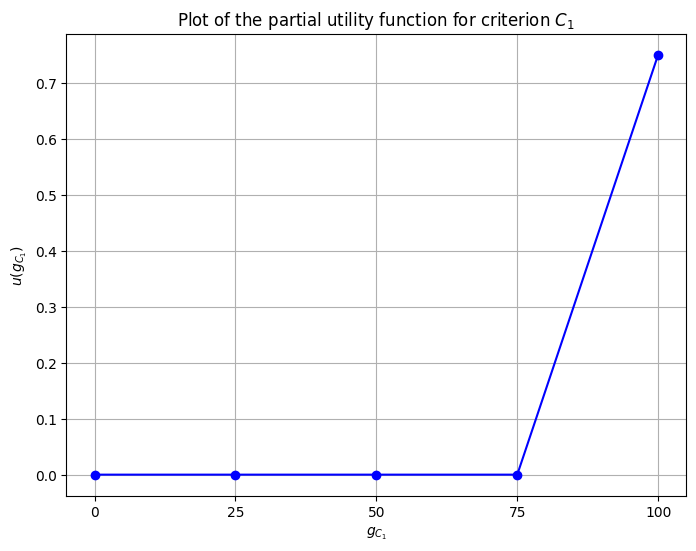

In [12]:
# This example demonstrates how to plot the partial utility function for criterion 1
solver_values = [value(criterion1_vars[val]) for val in criterion1_values]

plt.figure(figsize=(8, 6))
plt.plot(criterion1_values, solver_values, marker='o', linestyle='-', color='b', label='$u(g_{C_1})$')
plt.xlabel('$g_{C_1}$')
plt.ylabel('$u(g_{C_1})$')
plt.title('Plot of the partial utility function for criterion $C_1$')
plt.xticks(criterion1_values)
plt.grid(True)
plt.show()
